In [1]:
import numpy as np
%matplotlib ipympl
import matplotlib
import matplotlib.pyplot as plt;plt.rcParams['figure.dpi'] = 150;plt.rc('font', **{'size': 7})
from matplotlib.widgets import Slider, CheckButtons, RadioButtons, Button, RangeSlider
import os
from PIL import Image
import torch
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0, "../")
sys.path.insert(0, "../verifiers/")
from augmentations.fourier2d import fourier2d_augment
from augmentations.specification_networks import IDFT

tol = 1e-6

def load_image(img_path, shape):
    img_ = Image.open(img_path)  # c, h, w
    img_ = transforms.Resize(img_shape[-2:])(img_)
    img_ = transforms.ToTensor()(img_)
    return img_

def display_tensor(x, ax, label=None, transform=lambda x:x, normalise=False, **kwargs):
    x = x.detach().numpy() if torch.is_tensor(x) else x
    x = x if x.ndim==2 else x[0].transpose((1, 2, 0)) if x.ndim==4 else x.transpose((1, 2, 0))
    x = transform(x)
    if normalise:
        x = x if np.abs(x.max()) < tol else x/x.max()
    ax.imshow(x, **kwargs)
    if label is not None:
        ax.set_xlabel(label)

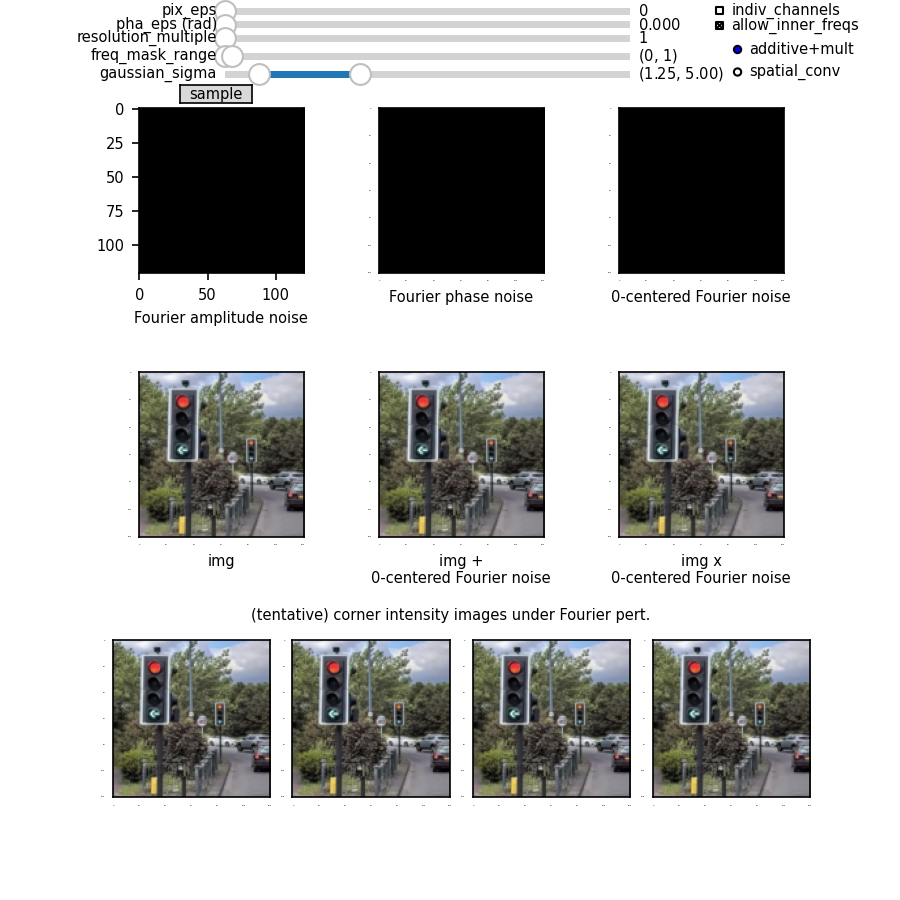

In [6]:
# AIM 1
img_shape = (3, 121, 121)
datadir = "datasets"
img_path = os.path.join(datadir, "traffic2.jpg")
img_ = load_image(img_path, img_shape)

N = img_shape[-1]

fvariables = {
    'pix_eps': {'valmin': 0., 'valmax': 5, 'valstep': 0.01, 'valinit': 0},
    'pha_eps (rad)': {'valmin': 0, 'valmax': np.pi, 'valstep': 0.1, 'valinit': 0},
    'resolution_multiple': {'valmin': 1, 'valmax': 4, 'valstep': 1, 'valinit': 1},
}
rvariables = {
    'freq_mask_range': {'valmin': 0, 'valmax': N//2+1, 'valstep': 1, 'valinit': (0, 1)},
    'gaussian_sigma': {'valmin': 0, 'valmax': N//8, 'valstep': 0.25, 'valinit': (1.25, 5)},
}
bvariables = {'indiv_channels': False, 'allow_inner_freqs': True}
bchoices = {'pert_model': ['additive+mult', 'spatial_conv']}

def augment_image(freq_mask_config, kernel_config, **kwargs):
    aug_out = fourier2d_augment(img_, strategy="aug", norm_ord=2, freq_mask_config=freq_mask_config, kernel_config=kernel_config, **kwargs)
    aug, amp_noise, pha_noise = aug_out[1], aug_out[-2], aug_out[-1] 
    if kwargs["pert_model"] == "additive+mult":
        idft = IDFT(N, concat_v=True, pert_model="additive", resolution_multiple=kwargs["resolution_multiple"])
        idft_mul = IDFT(N, concat_v=True, pert_model="spatial_mult", resolution_multiple=kwargs["resolution_multiple"])
        img_aug = [idft(aug, img_)[0], idft_mul(aug, img_)[0]]
    else:
        idft = IDFT(N, concat_v=True, pert_model=kwargs["pert_model"], resolution_multiple=kwargs["resolution_multiple"])
        img_aug = [idft(aug, img_)[0]]
    zero_centered_img_aug = idft(aug)[0]
    return aug, img_aug, zero_centered_img_aug, amp_noise, pha_noise

def augmentation_limits(freq_mask_config, kernel_config, **kwargs):
    lims = fourier2d_augment(img_, strategy="robust", norm_ord=2, freq_mask_config=freq_mask_config, kernel_config=kernel_config, **kwargs)[1]
    n = lims.shape[-2]
    r_l, r_u = lims[0][..., :n//2, :], lims[1][..., :n//2, :]
    i_l, i_u = lims[0][..., n//2:, :], lims[1][..., n//2:, :]
    idft = IDFT(N, concat_v=True, pert_model=kwargs["pert_model"].split('+')[0], resolution_multiple=kwargs["resolution_multiple"])
    return lims, idft(lims[0], img_), idft(torch.cat((r_l, i_u), dim=lims.ndim-3), img_), idft(torch.cat((r_u, i_l), dim=lims.ndim-3), img_), idft(lims[1], img_), (lims[1]-lims[0]).detach().numpy()

def on_variables_change(val=None):
    global fsliders, rsliders, checkbuttons, radiobuttons, axes1
    args = {k.split()[0]:float(s.val) for k, s in fsliders.items() if k != "pha_eps (rad)"}
    # args["pix_eps"] *= img_shape[-1]  # scaled here only to improve the perceptibility of the perturbations
    args = {**args, **{k.split()[0]:[s.val[0], s.val[1]] for k, s in rsliders.items()}}
    for bv, cb in zip(bvariables.keys(), checkbuttons.get_status()):
        args[bv] = cb
    for k, rb in radiobuttons.items():
        args[k] = rb.value_selected
    freq_mask_config = {k:v for k, v in args.items() if k in ["freq_mask_range", "allow_inner_freqs"]}
    kernel_config = {"kernel_type": "gaussian", "kernel_params_range": ({"sigma": args["gaussian_sigma"][0]}, {"sigma": args["gaussian_sigma"][1]})}
    kwargs = {k:v for k, v in args.items() if k not in ["freq_mask_range", "allow_inner_freqs", "gaussian_sigma"]}

    # get randomly augmented image and display
    aug, img_augs, zero_centered_img_aug, amp_noise, pha_noise = augment_image(freq_mask_config, kernel_config, **kwargs)
    img_aug = img_augs[0]
    axes = axes1[0]
    if kwargs["pert_model"] == "additive+mult":
        display_tensor(amp_noise, axes[0], "Fourier amplitude noise", np.fft.fftshift, normalise=True, cmap='gray', vmin=0, vmax=1)
        display_tensor(pha_noise, axes[1], "Fourier phase noise", np.fft.fftshift, normalise=True, cmap='gray', vmin=0, vmax=1)
        display_tensor(zero_centered_img_aug, axes[2], "0-centered Fourier noise")
        axes[2].set_visible(True)
    else:
        display_tensor(amp_noise, axes[0], "|DFT(kernel_sigma_u)|", np.fft.fftshift, cmap='gray', vmin=0, vmax=1)
        display_tensor(pha_noise, axes[1], "|DFT(kernel_sigma_l)|", np.fft.fftshift, cmap='gray', vmin=0, vmax=1)
        axes[2].set_visible(False)
    
    axes = axes1[1]
    display_tensor(img_, axes[0], "img")
    if kwargs["pert_model"] == "additive+mult":
        display_tensor(img_aug, axes[1], "img +\n0-centered Fourier noise")
        display_tensor(img_augs[1], axes[2], "img x\n0-centered Fourier noise")
        axes[2].set_visible(True)
    else:
        display_tensor(img_aug, axes[1], "img conv w/\nNormal K")
        axes[2].set_visible(False)
    # plot all sugmentation corners in the second row
    lims, img_ll, img_lu, img_ul, img_uu, rdiff = augmentation_limits(freq_mask_config, kernel_config, **kwargs)
    assert torch.min(aug-lims[0]) >= -tol and torch.min(lims[1]-aug) >= -tol, f"{torch.min(aug-lims[0])}!>0 {torch.min(lims[1]-aug)}!>0"
    axes = axes1[2]
    if kwargs["pert_model"] == "additive+mult":
        for ax in axes:
            ax.set_visible(True)
        display_tensor(img_ll, axes[0], "(tentative) corner intensity images under Fourier pert.")
        axes[0].xaxis.set_label_coords(2.15, 1.2)
        display_tensor(img_lu, axes[1])
        display_tensor(img_ul, axes[2])
        display_tensor(img_uu, axes[3])
        stats_str = f"pixel space l2-norm: {torch.norm(zero_centered_img_aug, p=2).item():.3f}, linf-norm: {torch.norm(zero_centered_img_aug, p=np.inf).item():.3f} " \
                    f"S:{list(img_.shape)} {np.prod(img_aug.shape)}, M_nz:{np.count_nonzero(amp_noise)} ({6*np.count_nonzero(amp_noise)}), , eps_nz_max: {np.count_nonzero(rdiff)} {rdiff.min():.3f} {rdiff.mean():.3f} {rdiff.max():.3f}\n" \
                    f"brightness: {torch.norm(img_, p=2).item()/np.sqrt(np.prod(img_shape)):.3f}, {torch.norm(img_aug, p=2).item()/np.sqrt(np.prod(img_shape)):.3f}, [{img_ll.mean().item():.3f}, {img_lu.mean().item():.3f}, {img_ul.mean().item():.3f}, {img_uu.mean().item():.3f}]" \
                    f", avg.diff: {(img_ll-img_).abs().mean().item():.3f}, {(img_lu-img_).abs().mean().item():.3f}, {(img_ul-img_).abs().mean().item():.3f}, {(img_uu-img_).abs().mean().item():.3f}, {(img_uu-img_ll).abs().mean().item():.3f}"
        # stats_text.set_text(stats_str)
    else:
        for ax in axes:
            ax.set_visible(False)
        stats_text.set_text("")
    for ax in [*axes1[0][1:], *axes1[1], *axes1[2]]:
        ax.tick_params(which = 'both', size = 0, labelsize = 0)
    plt.draw()
        
fig1 = plt.figure(figsize=(6, 6))
gs = fig1.add_gridspec(3, 12, hspace=0.6, wspace=0.6)
axes1 = [[fig1.add_subplot(gs[0, :4]), fig1.add_subplot(gs[0, 4:8]), fig1.add_subplot(gs[0, 8:])],
         [fig1.add_subplot(gs[1, :4]), fig1.add_subplot(gs[1, 4:8]), fig1.add_subplot(gs[1, 8:])],
        [fig1.add_subplot(gs[2, :3]), fig1.add_subplot(gs[2, 3:6]), fig1.add_subplot(gs[2, 6:9]), fig1.add_subplot(gs[2, 9:])]]
# stats_text = fig1.text(0, 0.03, 'Stats', ha='left')
fsliders = {}
for i, (v, vdata) in enumerate(fvariables.items()):
    s_ax  = fig1.add_axes([0.25, 0.98-0.015*i, 0.45, 0.015], facecolor='lightgoldenrodyellow')
    slider = Slider(s_ax, v, **vdata)
    slider.on_changed(on_variables_change)
    fsliders[v] = slider
rsliders = {}
for i, (v, vdata) in enumerate(rvariables.items()):
    s_ax  = fig1.add_axes([0.25, 0.93-0.02*i, 0.45, 0.015], facecolor='lightgoldenrodyellow')
    slider = RangeSlider(s_ax, v, **vdata)
    slider.on_changed(on_variables_change)
    rsliders[v] = slider
c_ax  = fig1.add_axes([0.78, 0.98-0.025, 0.13, 0.05], frame_on=False)
checkbuttons = CheckButtons(c_ax, list(bvariables.keys()), list(bvariables.values()))
checkbuttons.on_clicked(on_variables_change)
radiobuttons = {}
for i, (bk, bchoices_) in enumerate(bchoices.items()):
    bc_ax = fig1.add_axes([0.8, 0.99-0.025*(3.8+i), 0.13, 0.075], frame_on=False)
    radiobuttons[bk] = RadioButtons(bc_ax, bchoices_)
    radiobuttons[bk].on_clicked(on_variables_change)
b_ax = fig1.add_axes([0.2, 0.98-0.0165*5.75, 0.08, 0.02])
bnew = Button(b_ax, 'sample')
bnew.on_clicked(on_variables_change)
on_variables_change()

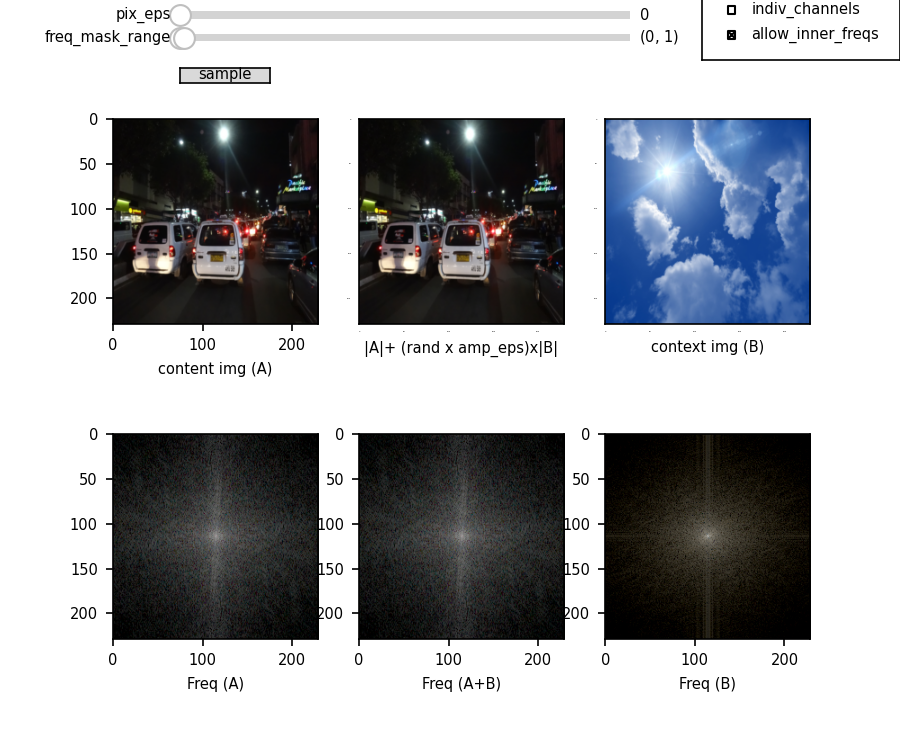

In [7]:
# AIM 2
from networks.network_impl import SegmentInterpolator

img_shape = (3, 229, 229)
datadir = "datasets"
img_path = os.path.join(datadir, "traffic10.jpg")  # os.listdir(datadir)[5])  cargo
domain_dir = f"{datadir}/domains/weather"
img2_path = os.path.join(domain_dir, os.listdir(domain_dir)[1])
img2_ = load_image(img2_path, img_shape)
img_ = load_image(img_path, img_shape)
# img_ = torch.ones(img_shape) * 0.5
# img_[:, 15:40, 17:42] = 0.25
# img_[:, 17:38, 19:40] = 0.5

N = img_shape[-1]
idft = IDFT(N, concat_v=True)

fvariables = {
    'pix_eps': {'valmin': 0., 'valmax': 1, 'valstep': 0.01, 'valinit': 0},
}
bvariables = {'indiv_channels': False, 'allow_inner_freqs': True}
rvariables = {'freq_mask_range': {'valmin': 0, 'valmax': N//2+1, 'valstep': 1, 'valinit': (0, 1)}}

def augment_image(freq_mask_config, **kwargs):
    x0, _, x1, _ = fourier2d_augment(img_, freq_mask_config=freq_mask_config, img2=img2_, **kwargs)
    segment_interpolator = SegmentInterpolator("cpu", "fourier", x0, x1)
    aug1 = segment_interpolator(np.random.random_sample()).unsqueeze(0)
    return idft(aug1)[0]

def on_variables_change(val=None):
    global fsliders, rsliders, axes1
    args = {k.split()[0]:s.val for k, s in fsliders.items()}
    args = {**args, **{k.split()[0]:[s.val[0], s.val[1]] for k, s in rsliders.items()}}
    for bv, cb in zip(bvariables.keys(), checkbuttons.get_status()):
        args[bv] = cb
    freq_mask_config = {k:v for k, v in args.items() if k in ["freq_mask_range", "allow_inner_freqs"]}
    kwargs = {k:v for k, v in args.items() if k not in ["freq_mask_range", "allow_inner_freqs"]}

    img_aug = augment_image(freq_mask_config, **kwargs)
    axes = axes1[0]
    display_tensor(img_, axes[0], "content img (A)")
    display_tensor(img_aug, axes[1], "|A|+ (rand x amp_eps)x|B|")
    display_tensor(img2_, axes[2], "context img (B)")
    for ax in axes[1:]:
        ax.tick_params(which = 'both', size = 0, labelsize = 0)

    def dft_viz(x_t):
        x = x_t.detach().numpy() if torch.is_tensor(x_t) else x_t
        x = np.clip(x, 0, 1)
        x = np.abs(np.fft.fftshift(np.fft.fft2(x, axes=(1,2)), axes=(1,2)))
        x = 20*np.log(x)
        # x = np.clip((x-x.min())/x.max(), 0, 1)
        x = np.clip(x, 0, 255).astype(np.uint8)
        return x.transpose((1, 2, 0))

    # add heatmaps of the original image phase and amplitudes
    axes = axes1[1]
    axes[0].imshow(dft_viz(img_))
    axes[0].set_xlabel("Freq (A)")
    axes[1].imshow(dft_viz(img_aug))
    axes[1].set_xlabel("Freq (A+B)")
    axes[2].imshow(dft_viz(img2_))
    axes[2].set_xlabel("Freq (B)")
    plt.draw()

# sliders for mask r,R; amplitude noise mag, phase noise mag
# plots for image, transformed image, amp noise, phase noise
fig1, axes1 = plt.subplots(2, 3, figsize=(6, 5))
fsliders = {}
for i, (v, vdata) in enumerate(fvariables.items()):
    s_ax  = fig1.add_axes([0.2, 0.97-0.02*i, 0.5, 0.02], facecolor='lightgoldenrodyellow')
    slider = Slider(s_ax, v, **vdata)
    slider.on_changed(on_variables_change)
    fsliders[v] = slider
rsliders = {}
for i, (v, vdata) in enumerate(rvariables.items()):
    s_ax  = fig1.add_axes([0.2, 0.94-0.02*i, 0.5, 0.02], facecolor='lightgoldenrodyellow')
    slider = RangeSlider(s_ax, v, **vdata)
    slider.on_changed(on_variables_change)
    rsliders[v] = slider
c_ax  = fig1.add_axes([0.78, 0.98-0.02*3, 0.22, 0.1])
checkbuttons = CheckButtons(c_ax, list(bvariables.keys()), list(bvariables.values()))
checkbuttons.on_clicked(on_variables_change)
b_ax = fig1.add_axes([0.2, 0.98-0.015*6, 0.1, 0.02])
bnew = Button(b_ax, 'sample')
bnew.on_clicked(on_variables_change)
on_variables_change()